# Task - 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from tabulate import tabulate
import os
import pickle


from sklearn.preprocessing import MultiLabelBinarizer, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import category_encoders as ce


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Step -1

### Loading Data

In [3]:
df = pd.read_csv('../Dataset.csv')
country_code = pd.read_excel('../Country Code.xlsx')

# merging both the datasets
df = pd.merge(df, country_code, on='Country Code',how='left')

In [4]:
df.head(2)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,Country
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Yes,No,No,No,3,4.8,Dark Green,Excellent,314,Phillipines
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Yes,No,No,No,3,4.5,Dark Green,Excellent,591,Phillipines


In [5]:
# creating a dataframe for dataset understanding

def basicInfo_data(dataframe):
    '''
    This function will provide the basic information (number of missing values, missing value percentage, unique value count, datatype of the feature) about the dataset.
    Input: DataFrame
    Output: DataFrame
    '''
    Features = []
    Missing_values = []
    Unique_value_count = []
    Missing_values_percentage = []
    datatype = []

    for col in dataframe.columns:
        Features.append(col)
        Missing_values.append(dataframe[col].isnull().sum())
        Missing_values_percentage.append(round((dataframe[col].isnull().sum()/dataframe.shape[0])*100,2))
        Unique_value_count.append(dataframe[col].nunique())
        datatype.append(dataframe[col].dtype)

    # filling the dataframe
    temp_df = pd.DataFrame({
        "Features": Features,
        "Missing_values":Missing_values,
        "Missing_value_percentage":Missing_values_percentage,
        "Unique_value_count":Unique_value_count,
        "Datatype":datatype
    })

    # display the dataframe
    return temp_df

In [6]:
basicInfo_data(df)

,Features,Missing_values,Missing_value_percentage,Unique_value_count,Datatype
0,Restaurant ID,0,0.0,9456,int64
1,Restaurant Name,0,0.0,7362,object
2,Country Code,0,0.0,15,int64
3,City,0,0.0,141,object
4,Address,0,0.0,8842,object
5,Locality,0,0.0,1208,object
6,Locality Verbose,0,0.0,1264,object
7,Longitude,0,0.0,8521,float64
8,Latitude,0,0.0,9079,float64
9,Cuisines,9,0.1,1811,object


In [7]:
def feature_types(dataframe):
    """This function will differentiate between the categorical, numerical, discrete and continous features.\n
    input: dataframe: DataFrame\n
    output: 1. categorical features: List\n
            2. numerical Features:List\n
            3. Discrete Features:List\n
            4. Continous Features:List"""
    cat_features = dataframe.select_dtypes(include='object').columns.to_list()
    num_features = dataframe.select_dtypes(exclude='object').columns.to_list()
    discrete_features = [feature for feature in num_features if len(dataframe[feature].unique())<=20]
    continous_features = [feature for feature in num_features if feature not in discrete_features]

    return cat_features, num_features, discrete_features, continous_features

### Feature Engineering

In [8]:
# creating column for values cost_per_person
df['cost'] = df['Average Cost for two']/2


# removing useless features
df.drop(columns=['Restaurant ID','Average Cost for two',
                 'Country Code','Switch to order menu', 'Rating color'],
        axis=1, inplace=True)


# renaming columns
df.rename(columns={'Has Table booking':'Booking',
                    'Has Online delivery':'Online_delivery',
                    'Is delivering now':'Deliver_now',
                    'Restaurant Name':'Name',
                    'Rating text':'Rating_text'}
         ,inplace=True)

In [11]:
# categorical features
categorical_features,_,_,_ = feature_types(df)
categorical_features

['Name',
 'City',
 'Address',
 'Locality',
 'Locality Verbose',
 'Cuisines',
 'Currency',
 'Booking',
 'Online_delivery',
 'Deliver_now',
 'Rating_text',
 'Country']

In [12]:
# checking for duplicate values
df.duplicated(subset=['Name', 'Address']).sum()

0

In [13]:
df.head(2)

,Name,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Currency,Booking,Online_delivery,Deliver_now,Price range,Aggregate rating,Rating_text,Votes,Country,cost
0,Le Petit Souffle,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",Botswana Pula(P),Yes,No,No,3,4.8,Excellent,314,Phillipines,550.0
1,Izakaya Kikufuji,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,Botswana Pula(P),Yes,No,No,3,4.5,Excellent,591,Phillipines,600.0


In [14]:
# Removing the unnecessary features
df1 = df[['City', 'Cuisines', 'Booking', 'Online_delivery',
       'Deliver_now', 'Price range', 'Aggregate rating', 'Rating_text',
       'Votes', 'Country', 'cost']]

In [15]:
# Ensure Cuisines column exists and fill NaN values with an empty list
df1['Cuisines'] = df1['Cuisines'].fillna('').apply(lambda x: x.split(',') if x != '' else [])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit-transform and create DataFrame
cuisines_encoding = mlb.fit_transform(df1['Cuisines'])
multi_cuisines_df = pd.DataFrame(cuisines_encoding, columns=mlb.classes_).astype(int)

# Drop original Cuisines column and merging
df1 = df1.drop(columns=['Cuisines']).join(multi_cuisines_df)

# saving the MultiLabelBinarizer
pickle.dump(mlb, open('MultiLabelBinarizer.pkl', 'wb'))


In [16]:
df1.head()

,City,Booking,Online_delivery,Deliver_now,Price range,Aggregate rating,Rating_text,Votes,Country,cost,...,Tapas,Tea,Tex-Mex,Thai,Tibetan,Turkish,Turkish Pizza,Vietnamese,Western,World Cuisine
0,Makati City,Yes,No,No,3,4.8,Excellent,314,Phillipines,550.0,...,0,0,0,0,0,0,0,0,0,0
1,Makati City,Yes,No,No,3,4.5,Excellent,591,Phillipines,600.0,...,0,0,0,0,0,0,0,0,0,0
2,Mandaluyong City,Yes,No,No,4,4.4,Very Good,270,Phillipines,2000.0,...,0,0,0,0,0,0,0,0,0,0
3,Mandaluyong City,No,No,No,4,4.9,Excellent,365,Phillipines,750.0,...,0,0,0,0,0,0,0,0,0,0
4,Mandaluyong City,Yes,No,No,4,4.8,Excellent,229,Phillipines,750.0,...,0,0,0,0,0,0,0,0,0,0


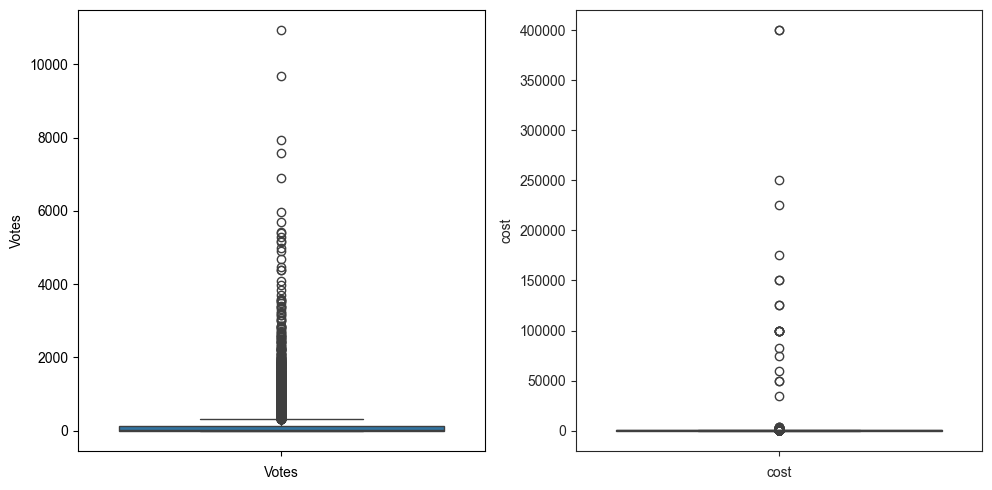

In [17]:
# checking for outliers in continous features
features = df1[['Votes','cost']].columns
plt.figure(figsize=(15,5))
for i in range(len(features)):
    plt.subplot(1, 3, i + 1)  # 3 rows, 6 columns
    sns.set_style('ticks')
    plt.xlabel(features[i])
    ax = sns.boxplot(df1[features[i]])
plt.tight_layout()

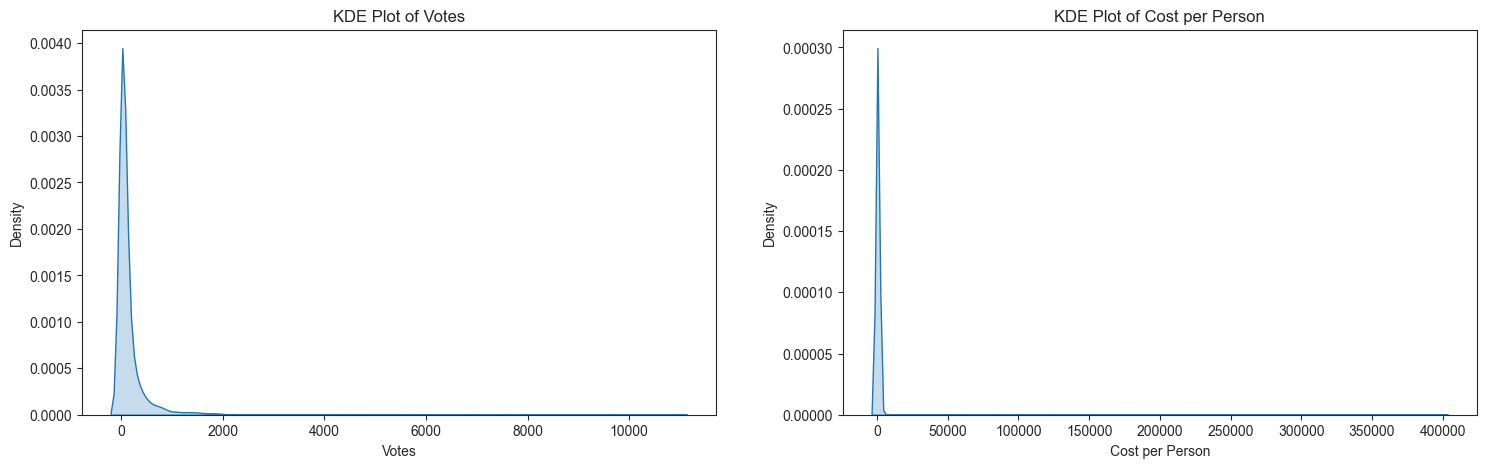

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 5))

# Use sns.kdeplot() instead of sns.displot()
sns.kdeplot(df1['Votes'], ax=ax[0], fill=True)
ax[0].set_xlabel('Votes')
ax[0].set_title('KDE Plot of Votes')

sns.kdeplot(df1['cost'], ax=ax[1], fill=True)
ax[1].set_xlabel('Cost per Person')
ax[1].set_title('KDE Plot of Cost per Person')

plt.show()

### Outlier Handling

In [19]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    """This function will calculate the lower limit and the upper limit which is required for calculating the thresholds.\n
    input: dataframe:DataFrame\n
           column name: str\n
           first quartile: float\n
           third quartile: float\n
    output: lower limit: float\n
            upper limit: float"""
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit


def check_outliers_iqr(dataframe, col_name):
    """This function will check if a particular column is having outliers or not.\n
    input: dataframe: DataFrame\n
           col_name:str\n
    output: bool"""
    lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds_iqr(dataframe,cols, th1=0.05, th3=0.95, replace=False):
    data = []
    for col_name in cols:
        if col_name != 'Aggregate rating':
            outliers_ = check_outliers_iqr(df,col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name, th1, th3)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                if replace:
                    if lower_limit < 0:
                        # We don't want to replace with negative values, right!
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                    else:
                        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
            outliers_status = check_outliers_iqr(df, col_name)
            data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit ])
    table = tabulate(data, headers=['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using IQR")
    print(table)
    return dataframe

In [20]:
temp_df = df1[['Votes','cost']]
temp_df = replace_with_thresholds_iqr(dataframe=temp_df, cols=temp_df.columns,
                                     th1=0.25, th3=0.75 ,replace=True)

# # replacing the values in the data
df1.iloc[:,7:8] = temp_df['Votes']
df1.iloc[:,9:10] = temp_df['cost']

Removing Outliers using IQR
=======================  ==========  =======  ========  =============  =============
Outliers (Previously)    Outliers      Count  Column      Lower Limit    Upper Limit
=======================  ==========  =======  ========  =============  =============
True                     True           1117  Votes            -185.5          322.5
True                     True            853  cost             -212.5          687.5
=======================  ==========  =======  ========  =============  =============


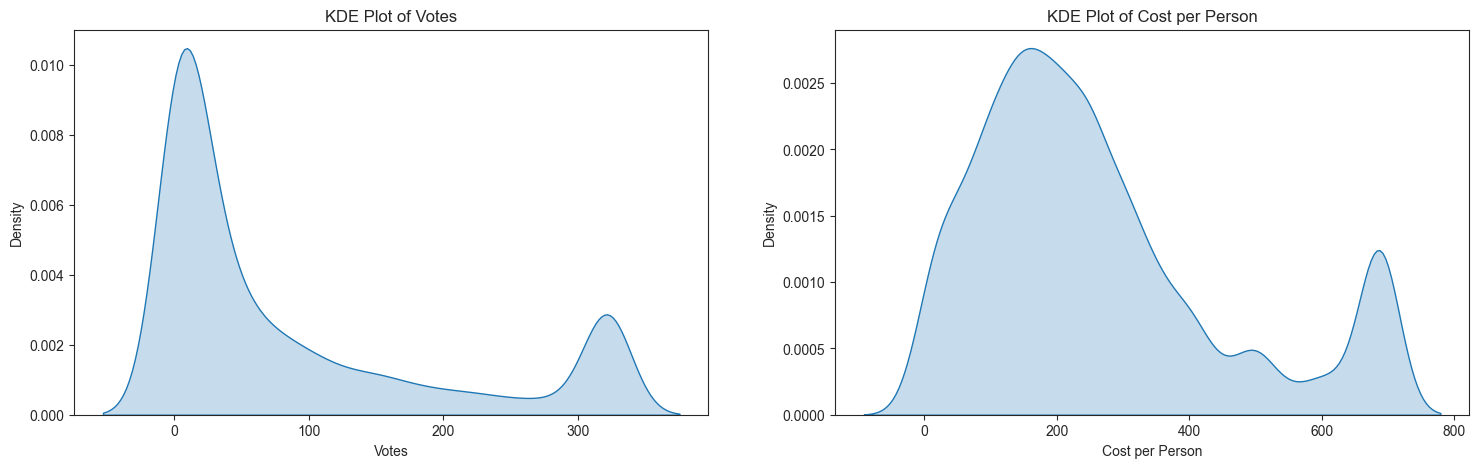

In [21]:
# after oultier handling
fig, ax = plt.subplots(ncols=2, figsize=(18, 5))

# Use sns.kdeplot() instead of sns.displot()
sns.kdeplot(df1['Votes'], ax=ax[0], fill=True)
ax[0].set_xlabel('Votes')
ax[0].set_title('KDE Plot of Votes')

sns.kdeplot(df1['cost'], ax=ax[1], fill=True)
ax[1].set_xlabel('Cost per Person')
ax[1].set_title('KDE Plot of Cost per Person')

plt.show()

In [22]:
df1.head()

,City,Booking,Online_delivery,Deliver_now,Price range,Aggregate rating,Rating_text,Votes,Country,cost,...,Tapas,Tea,Tex-Mex,Thai,Tibetan,Turkish,Turkish Pizza,Vietnamese,Western,World Cuisine
0,Makati City,Yes,No,No,3,4.8,Excellent,314.0,Phillipines,550.0,...,0,0,0,0,0,0,0,0,0,0
1,Makati City,Yes,No,No,3,4.5,Excellent,322.5,Phillipines,600.0,...,0,0,0,0,0,0,0,0,0,0
2,Mandaluyong City,Yes,No,No,4,4.4,Very Good,270.0,Phillipines,687.5,...,0,0,0,0,0,0,0,0,0,0
3,Mandaluyong City,No,No,No,4,4.9,Excellent,322.5,Phillipines,687.5,...,0,0,0,0,0,0,0,0,0,0
4,Mandaluyong City,Yes,No,No,4,4.8,Excellent,229.0,Phillipines,687.5,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df1.shape

(9456, 259)

### Feature Scaling

In [24]:
X = df1.drop(columns=['Aggregate rating'], axis=1)
y = df1['Aggregate rating']

X.shape   # (9456, 10)

(9456, 258)

In [25]:
x_raw = X.copy()

In [26]:
# Defining column groups
rating_text_order = [['Not rated','Poor', 'Average', 'Good', 'Very Good', 'Excellent']]

target_enc_cols = ['City','Country']
ordinal_enc_cols = ['Rating_text']
numeric_cols = ['Price range', 'Votes', 'cost']
categorical_cols = ['Booking', 'Online_delivery', 'Deliver_now']

# Defining Preprocessor
preprocessor = ColumnTransformer([
    ('target_enc', TargetEncoder(), target_enc_cols),
    ('ordinal_enc', OrdinalEncoder(categories=rating_text_order), ordinal_enc_cols),
    ('one_hot_enc', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
], remainder='passthrough')


In [ ]:
models = {
    'Linear_regression':LinearRegression(),
    'SVR':SVR(),
    'Ridge':Ridge(),
    'LASSO':Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest':RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Adaboost': AdaBoostRegressor()
}

def model_scorer(model_name, model):
    output = []
    output.append(model_name)

    # pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')

    output.append(scores.mean())

    # splitting data into train and test set
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    pipeline.fit(x_train, y_train)

    y_pred = pipeline.predict(x_test)

    output.append(mean_absolute_error(y_test, y_pred))

    return output

In [28]:
model_output = []
for model_name, model in models.items():
    model_output.append(model_scorer(model_name, model))

In [29]:
# creating a dataframe
model_df  =pd.DataFrame(model_output, columns=['Name', 'R2 Score', 'MAE'])
model_df.sort_values(['MAE'])

,Name,R2 Score,MAE
5,Random Forest,0.985993,0.119305
7,Gradient Boosting,0.987161,0.120024
6,Extra Trees,0.984271,0.122521
1,SVR,0.985123,0.134682
8,Adaboost,0.983332,0.139156
4,Decision Tree,0.975169,0.149075
2,Ridge,0.907651,0.381578
0,Linear_regression,0.905599,0.383628
3,LASSO,0.652137,0.737468


Selecting the `Random Forest` as the final ML model as it shows the minimum MAE (Mean Absolute error) and a mean R2 score of 0.98

### Hyperparameter Tuning

In [30]:
# Splitting data properly
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],  # Fewer values for efficiency
    'regressor__max_depth': [None, 10, 20],
    'regressor__max_samples': [0.1, 0.25, 0.5],
    'regressor__max_features': ['sqrt', 'log2']  # 'auto' is deprecated
}

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with parallel processing
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=2)
search.fit(x_train, y_train)

# Print best parameters
print(f"Best Parameters: {search.best_params_}")

# Evaluate on test set
best_model = search.best_estimator_
test_score = best_model.score(x_test, y_test)
print(f"Test R² Score: {test_score:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__max_samples': 0.5, 'regressor__n_estimators': 200}
Test R² Score: 0.9794


In [31]:
# Reuse the existing preprocessor
best_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_samples=0.5)  # Use best hyperparameters

# Define the final pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Reuse the same preprocessor
    ('regressor', best_model)  # Apply best-tuned model
])

# Train the final model
pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_enc', TargetEncoder(),
                                                  ['City', 'Country']),
                                                 ('ordinal_enc',
                                                  OrdinalEncoder(categories=[['Not '
                                                                              'rated',
                                                                              'Poor',
                                                                              'Average',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Excellent']]),
                                                  ['Rating_text']),
                                                 ('one_hot_enc',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Booking', 'Online_delivery',
                                                   'Deliver_now']),
                                                 ('scaler', StandardScaler(),
                                                  ['Price range', 'Votes',
                                                   'cost'])])),
                ('regressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5))])

In [32]:
# Exporting the final trained pipeline
pickle.dump(pipeline, open('restaurant_rating_pipeline.pkl', 'wb'))

In [33]:
# loading the pipeline
loaded_pipeline = pickle.load(open('restaurant_rating_pipeline.pkl', 'rb'))


# Predict on test data WITHOUT manual preprocessing
test_predictions = loaded_pipeline.predict(x_test)
print("Predicted Ratings on Test Data:", test_predictions)
print("Test predictions saved successfully!")

Predicted Ratings on Test Data: [3.05783333 0.         0.         ... 0.         3.085      2.87425   ]
Test predictions saved successfully!


In [34]:
def predict_rating(new_data, mlb_path='MultiLabelBinarizer.pkl', pipeline_path='restaurant_rating_pipeline.pkl'):
    """
    Predict restaurant rating based on new input data.

    Parameters:
    - new_data (pd.DataFrame): DataFrame containing new restaurant data.
    - mlb_path (str): Path to the saved MultiLabelBinarizer model.
    - pipeline_path (str): Path to the saved preprocessing + model pipeline.

    Returns:
    - float: Predicted rating for the new restaurant.
    """

    # Step 1: Load MultiLabelBinarizer & Apply Transformation
    with open(mlb_path, 'rb') as f:
        mlb = pickle.load(f)

    new_data['Cuisines'] = new_data['Cuisines'].fillna('').apply(lambda x: x.split(',') if x != '' else [])

    cuisine_encoded = mlb.transform(new_data['Cuisines'])
    cuisine_df = pd.DataFrame(cuisine_encoded, columns=mlb.classes_).astype(int)

    new_data = new_data.drop(columns=['Cuisines']).join(cuisine_df)

    # Step 2: Load Preprocessing + Model Pipeline
    with open(pipeline_path, 'rb') as f:
        pipeline = pickle.load(f)

    # Step 3: Predict Using the Pipeline
    prediction = pipeline.predict(new_data)

    return round(prediction[0], 2)  # Returning rounded prediction

In [35]:
# Example usage
new_data = pd.DataFrame([{
    'City': 'New York',
    'Booking': 'Yes',
    'Online_delivery': 'No',
    'Deliver_now': 'Yes',
    'Price range': 3,
    'Rating_text':'Very Good',
    'Votes': 250,
    'Country': 'USA',
    'cost': 15,
    'Cuisines': 'Italian'
}])

predicted_rating = predict_rating(new_data)
print(f"Predicted rating: {predicted_rating}")

Predicted rating: 3.87
